In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
#dataset:https://github.com/CSSEGISandData/COVID-19
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

confirmed_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = death_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

full_table = confirmed_table.merge(death_table).merge(recovered_table)

full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table




,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,2020-01-22,0,0,0
1,,Albania,2020-01-22,0,0,0
2,,Algeria,2020-01-22,0,0,0
3,,Andorra,2020-01-22,0,0,0
4,,Angola,2020-01-22,0,0,0
...,...,...,...,...,...,...
56947,,West Bank and Gaza,2020-09-03,24471,167,16095
56948,,Western Sahara,2020-09-03,10,1,8
56949,,Yemen,2020-09-03,1979,571,1180
56950,,Zambia,2020-09-03,12523,292,11562


In [3]:
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered,Active
0,,Afghanistan,2020-01-22,0,0,0,0
1,,Albania,2020-01-22,0,0,0,0
2,,Algeria,2020-01-22,0,0,0,0
3,,Andorra,2020-01-22,0,0,0,0
4,,Angola,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...
56947,,West Bank and Gaza,2020-09-03,24471,167,16095,8209
56948,,Western Sahara,2020-09-03,10,1,8,1
56949,,Yemen,2020-09-03,1979,571,1180,228
56950,,Zambia,2020-09-03,12523,292,11562,669


In [4]:
def get_time_series(country):
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed', 'Deaths', 'Recovered', 'Active'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]


def get_time_series_province(province):
    df = full_table[(full_table['Province/State'] == province)]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]

In [5]:
country = 'India'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail(10)

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-08-25,3224547,59357,2458339,706851
2020-08-26,3310234,60472,2523771,725991
2020-08-27,3387500,61529,2583948,742023
2020-08-28,3463972,62550,2648998,752424
2020-08-29,3542733,63498,2713933,765302
2020-08-30,3621245,64469,2774801,781975
2020-08-31,3691166,65288,2839882,785996
2020-09-01,3769523,66333,2901908,801282
2020-09-02,3853406,67376,2970492,815538


In [6]:
import math
def model_with_lag(N, a, alpha, lag, t):
    lag = min(max(lag, -100), 100) # lag must be less than +/- 100 days 
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [7]:
model_index = 0

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
#         r += (math.log(1 + model(N, a, alpha, t)) - math.log(1 + df.iloc[t, 0])) ** 2 
#         r += (model_with_lag(N, a, alpha, lag, t) - df.iloc[t, 0]) ** 2
#         print(model(N, a, alpha, t), df.iloc[t, 0])
    return math.sqrt(r) 

In [8]:
import numpy as np
from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x

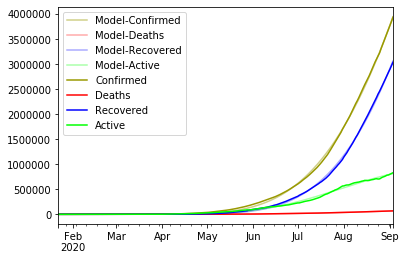

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

model_sim['Model-Active'] = model_sim['Model-Confirmed'] - model_sim['Model-Deaths'] - model_sim['Model-Recovered']
model_sim.loc[model_sim['Model-Active']<0,'Model-Active'] = 0
plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([model_sim, df], axis=1).plot(color = plot_color)
plt.show()



India COVID-19 Prediction


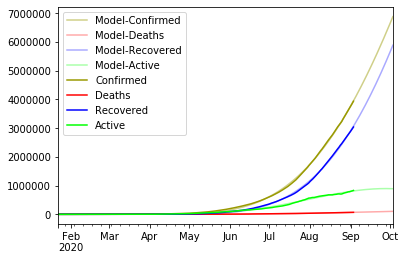

In [10]:
import datetime
start_date = df.index[0]
n_days = len(df) + 30
extended_model_x = []
last_row = []

isValid = True
last_death_rate = 0

for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
    
    #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
    if (t > len(df)):
        last_row = extended_model_x[-1]
        if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.12):
            if (isValid):
                last_row2 = extended_model_x[-2]
                last_death_rate = last_row2[2]/last_row2[1]
                isValid = False

        if (last_row[2] > last_row[1]*0.05):
            last_row[2] = last_row[1]*last_death_rate
            
        if (last_row[2] + last_row[3] > last_row[1]):
            last_row[2] = last_row[1]*last_death_rate
            last_row[3] = last_row[1]*(1-last_death_rate)

extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)

extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']
extended_model_sim['Model-Active'] = extended_model_sim['Model-Confirmed'] - extended_model_sim['Model-Deaths'] - extended_model_sim['Model-Recovered']
extended_model_sim.loc[extended_model_sim['Model-Active']<0,'Model-Active'] = 0

plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([extended_model_sim, df], axis=1).plot(color = plot_color)
print('India COVID-19 Prediction')
plt.show()



In [11]:
df.tail()

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-08-30,3621245,64469,2774801,781975
2020-08-31,3691166,65288,2839882,785996
2020-09-01,3769523,66333,2901908,801282
2020-09-02,3853406,67376,2970492,815538
2020-09-03,3936747,68472,3037151,831124


In [12]:
df.head()

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-01-22,0,0,0,0
2020-01-23,0,0,0,0
2020-01-24,0,0,0,0
2020-01-25,0,0,0,0
2020-01-26,0,0,0,0


In [13]:
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 3 == 0]

,Confirmed,Deaths,Recovered,Active,Model-Confirmed,Model-Deaths,Model-Recovered,Model-Active
2020-01-24,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0
2020-01-30,1,0,0,1,0,0,0,0
2020-02-03,3,0,0,3,0,0,0,0
2020-02-06,3,0,0,3,0,0,0,0
2020-02-09,3,0,0,3,0,0,0,0
2020-02-12,3,0,0,3,0,0,0,0
2020-02-15,3,0,0,3,0,0,0,0
2020-02-18,3,0,3,0,0,0,0,0
2020-02-21,3,0,3,0,0,0,0,0
